In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, or_, desc

In [6]:
database_path = "sqlite:///Resources/hawaii.sqlite"
engine = create_engine(database_path)

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect= True)

In [8]:
# engine.table_names()
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurements = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

#### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [18]:
#get the last date
last_date = session.query(func.max(Measurements.date)).first()[0]
last_date

'2017-08-23'

In [19]:
#convert date string to datetime object
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
last_date

datetime.datetime(2017, 8, 23, 0, 0)

In [20]:
#extract year, month, and day as integers
last_year = int(dt.datetime.strftime(last_date, '%Y'))
last_month = int(dt.datetime.strftime(last_date, '%m'))
last_day = int(dt.datetime.strftime(last_date, '%d'))

In [21]:
#calculate one year before latest date
dt_year_before = dt.date(last_year, last_month, last_day) - relativedelta(months=12)
dt_year_before

datetime.date(2016, 8, 23)

In [22]:
# Perform a query to retrieve precipitation scores associated with last year date
sel = [Measurements.date,
       Measurements.prcp]

lastyear_prcpdata = session.query(*sel).\
    filter(and_(Measurements.date <= last_date, Measurements.date >= dt_year_before)).\
    order_by(Measurements.date).all()
lastyear_prcpdata

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

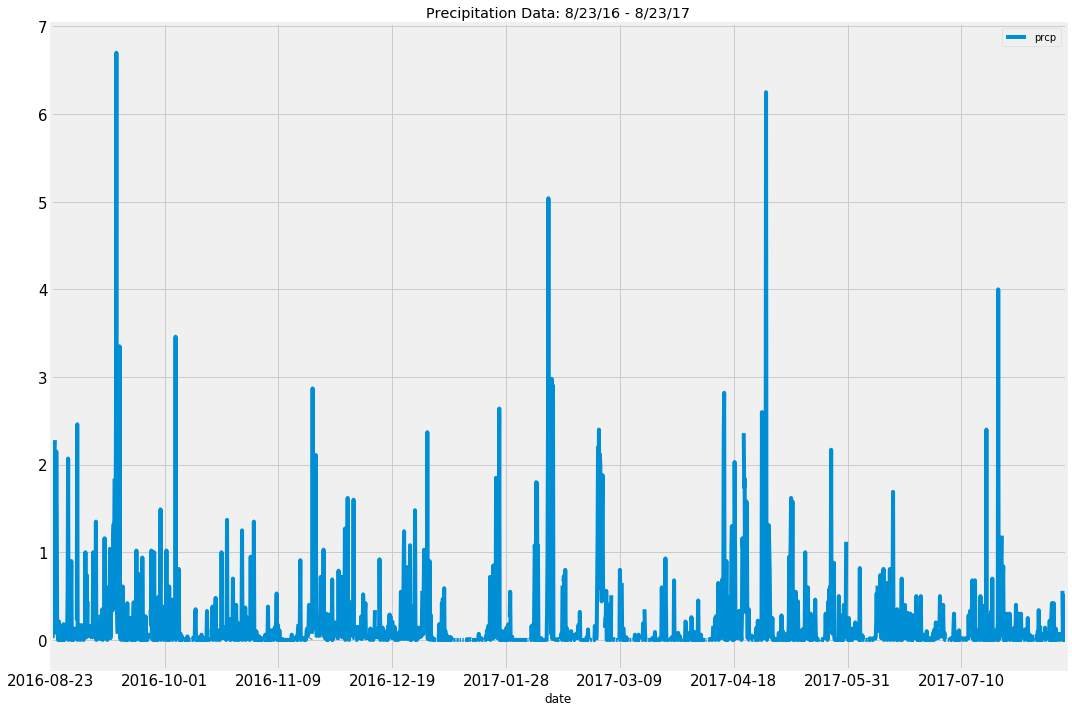

In [47]:
# Save the query results as a Pandas DataFrame and set the index to the date column
lastyear_prcp_df = pd.DataFrame(lastyear_prcpdata)
# set the date as index.
lastyear_prcp_df.set_index('date', inplace = True)
# Sort the dataframe by date
lastyear_prcp_df.sort_index(ascending=True, inplace=True)

lastyear_prcp_df.plot(title="Precipitation Data: 8/23/16 - 8/23/17", fontsize = 15, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [48]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_stat_summary = pd.DataFrame(lastyear_prcp_df["prcp"].describe())
prcp_stat_summary

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [49]:
# Design a query to show how many stations are available in this dataset?
no_of_stations = session.query(Station).count()
no_of_stations

9

In [50]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [Measurements.station,
       func.count(Measurements.station).label('no_of_stations')]
count_per_station = session.query(*sel).\
                        group_by(Measurements.station).\
                        order_by(desc('no_of_stations')).all()
count_per_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [51]:
# Most active station.
most_active_station = count_per_station[0][0]
# most_active_station = list(np.ravel(most_active_station))
active_station_name = session.query(Station.name).\
                              filter(Station.station == most_active_station).all()
print(f"Most active station is:: {most_active_station}-{active_station_name[0][0]}")


Most active station is:: USC00519281-WAIHEE 837.5, HI US


In [52]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sel =[func.min(Measurements.tobs),
     func.max(Measurements.tobs),
     func.avg(Measurements.tobs)]

temp_stat = session.query(*sel).\
                    filter(Measurements.station == most_active_station).all()
temp_stat
print(f"Temperature data for most active station ({most_active_station}).")
print(f"-----------------------------------------")
print(f"Minimum Temperature: {temp_stat[0][0]}")
print(f"Maximum Temperature: {temp_stat[0][1]}")
print(f"Average Temperature: {temp_stat[0][2]}")

Temperature data for most active station (USC00519281).
-----------------------------------------
Minimum Temperature: 54.0
Maximum Temperature: 85.0
Average Temperature: 71.66378066378067


In [53]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [Measurements.date,
       Measurements.tobs]

lastyear_tobs = session.query(*sel).\
    filter(Measurements.station == most_active_station).\
    filter(and_(Measurements.date <= last_date, Measurements.date >= dt_year_before)).\
    order_by(Measurements.date).all()
lastyear_tobs

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

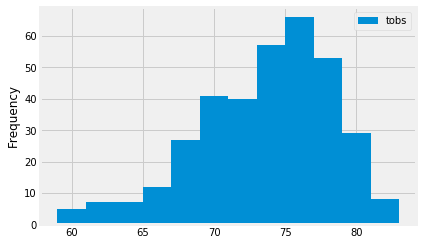

In [54]:
tobs_most_active_station = pd.DataFrame(lastyear_tobs)
# set date as index
tobs_most_active_station.set_index('date', inplace = True)
# sort date by ascending order
tobs_most_active_station.sort_index(ascending=True, inplace=True)
# plot histogram
tobs_most_active_station.plot(kind ="hist", bins=12)